In [2]:
#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string
import emoji
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

/tmp/ipykernel_31/4133411131.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 640x480 with 0 Axes>

In [3]:
df = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_train.csv',encoding='ISO-8859-1')
df_test = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_test.csv')

In [4]:
df.head()

UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


# Data Cleaning

### 1- Converting the "TweetAt" column to datetime. 
### 2- check the duplicates 
### 3- check nan values

In [7]:
# Converting the "TweetAt" columns to pandas datetime format
df['TweetAt'] = pd.to_datetime(df['TweetAt'])

In [9]:
## check duplicates
df.duplicated().sum()

0

# Exploring our dataset by using Exploratory Data analysis: 

### **Number of tweets per day** :

In [10]:
tweets_per_day = df['TweetAt'].dt.strftime('%m-%d').value_counts().sort_index().reset_index(name='counts')

/tmp/ipykernel_31/539433254.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.barplot(x='TweetAt', y='counts', data=tweets_per_day,edgecolor = 'black',ci=False, palette='Blues_r')


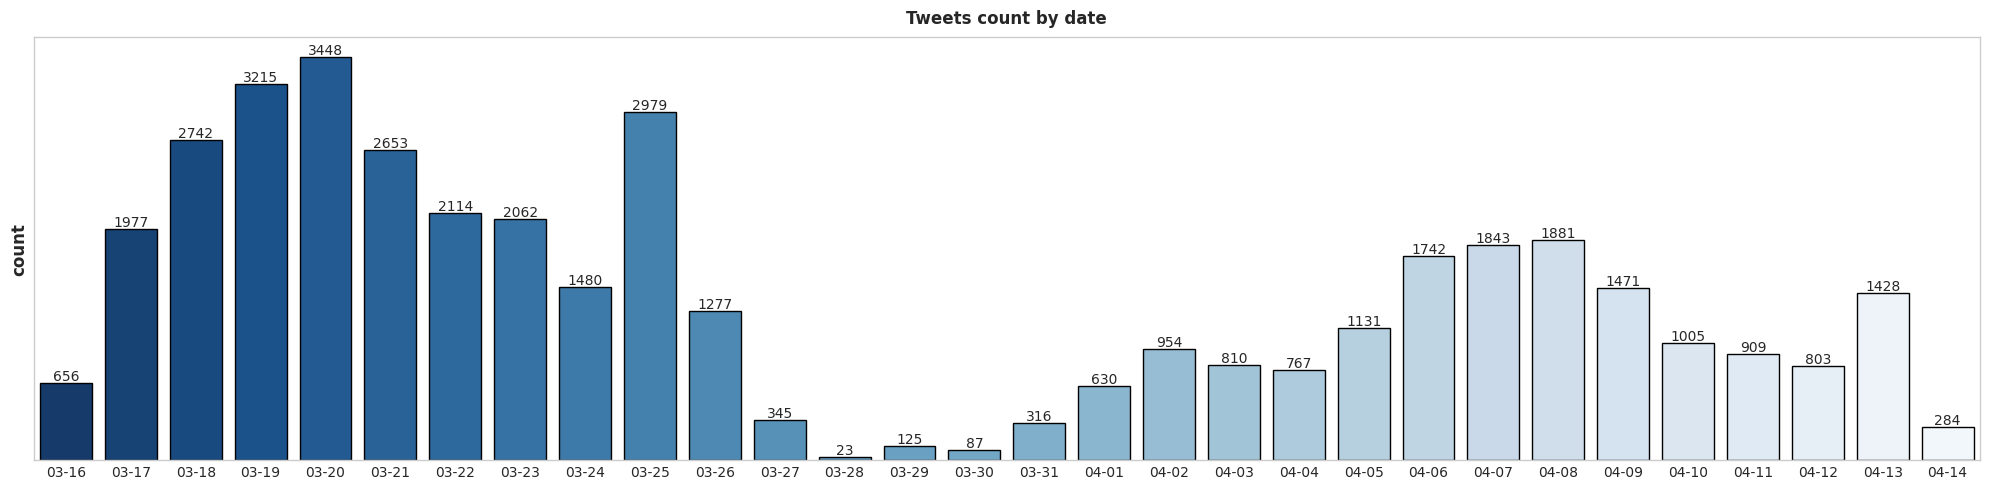

In [13]:
plt.figure(figsize=(20,5))
ax = sns.barplot(x='TweetAt', y='counts', data=tweets_per_day,edgecolor = 'black',ci=False, palette='Blues_r')
plt.title('Tweets count by date')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

from the bar chart above, we notice that in the dataset there are some days without tweets in the dataset. Among the days with tweets, most of them are made around the end of March: from 18th of Match to the 26th of March.

### Number of tweets per Country & City

In [15]:
tweets_per_country = df['Location'].value_counts().loc[lambda x : x > 100].reset_index(name='counts')

/tmp/ipykernel_31/2328869165.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.barplot(x='Location', y='counts', data=tweets_per_country,edgecolor = 'black',ci=False, palette='Spectral')


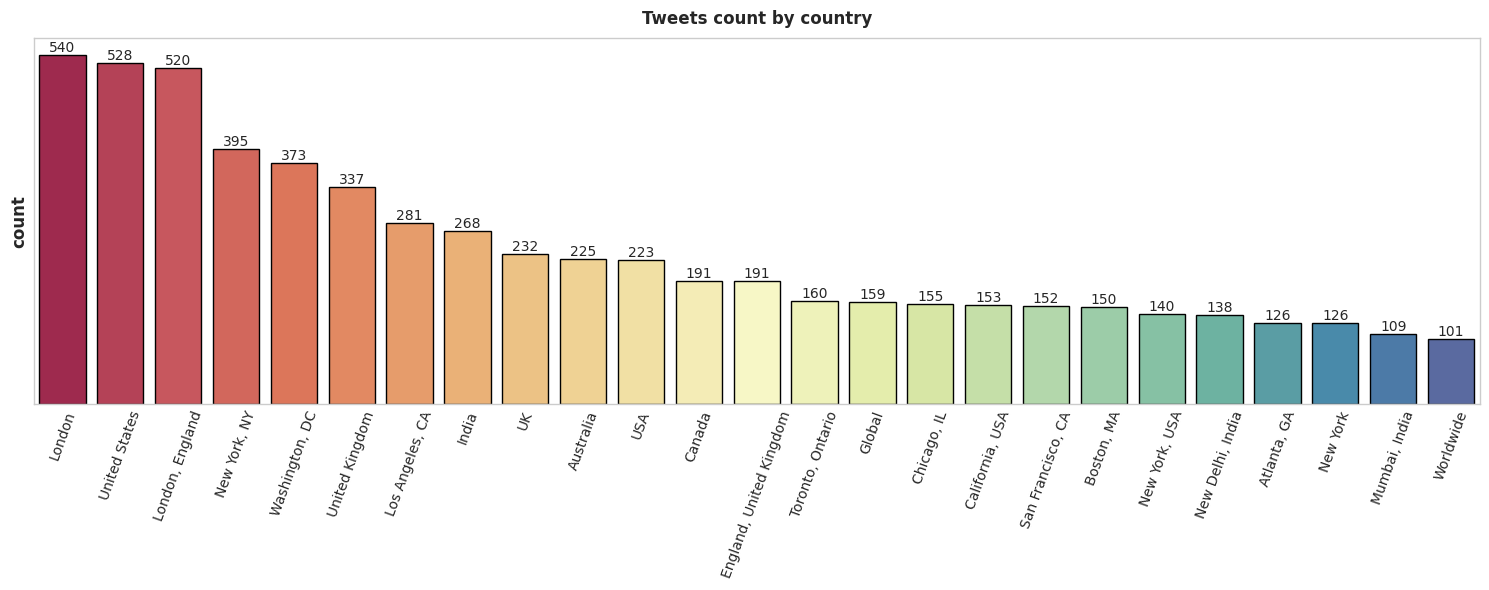

In [18]:
plt.figure(figsize=(15,6))
ax = sns.barplot(x='Location', y='counts', data=tweets_per_country,edgecolor = 'black',ci=False, palette='Spectral')
plt.title('Tweets count by country')
plt.xticks(rotation=70)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

The chart above explain that the 'location' column contains both countries and cities. It could be interesting to separate cities and countries, however this wont be investigated in this work.

# Data Preprocessing 

 we will just keep the columns 'Originaltweet' (raw tweets) and the target column 'Sentiment'.

In [19]:
df = df[['OriginalTweet','Sentiment']]

In [20]:
df_test = df_test[['OriginalTweet','Sentiment']]

In [26]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

#Clean emojis from text
def strip_emoji(text):
    return emoji.replace_emoji(text,replace = '') #remove emoji

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [27]:
texts_new = []
for t in df.OriginalTweet:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [28]:
texts_new_test = []
for t in df_test.OriginalTweet:
    texts_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

Now we will create a new column, for both train and test sets, to host the cleaned version of the tweets' text.

In [29]:
df['text_clean'] = texts_new
df_test['text_clean'] = texts_new_test

In [30]:
df['text_clean'].head()

0                                              and and
1    advice talk to your neighbours family to excha...
2    coronavirus australia woolworths to give elder...
3    my food stock is not the only one which is emp...
4    me ready to go at supermarket during the covid...
Name: text_clean, dtype: object

In [31]:
df_test['text_clean'].head()

0    trending new yorkers encounter empty supermark...
1    when i couldnt find hand sanitizer at fred mey...
2    find out how you can protect yourself and love...
3    panic buying hits newyork city as anxious shop...
4    toiletpaper dunnypaper coronavirus coronavirus...
Name: text_clean, dtype: object

In [32]:
df['text_clean'][1:8].values

array(['advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order',
       'coronavirus australia woolworths to give elderly disabled dedicated shopping hours amid covid19 outbreak',
       'my food stock is not the only one which is empty please dont panic there will be enough food for everyone if you do not take more than you need stay calm stay safe covid19france covid19 covid19 coronavirus confinement confinementotal confinementgeneral',
       'me ready to go at supermarket during the covid19 outbreak not because im paranoid but because my food stock is litteraly empty the coronavirus is a serious thing but please dont panic it causes shortage coronavirusfrance restezchezvous stayathome confinement',
       'as news of the regions first confirmed covid19 case came out of sullivan county last week people 

Moreover, we will also create a column to host the lenght of the cleaned text, to check if by cleaning the text we removed too much text or almost entirely the tweet!

In [33]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [35]:
df['text_len'] = text_len

In [36]:
text_len_test = []
for text in df_test.text_clean:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

In [37]:
df_test['text_len'] = text_len_test

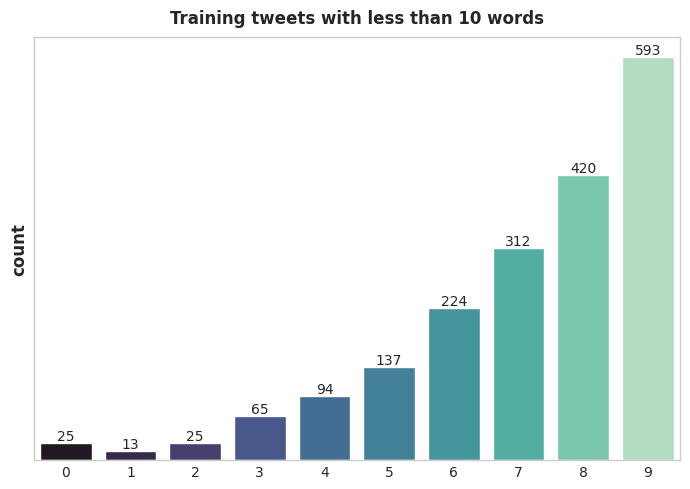

In [38]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Training tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

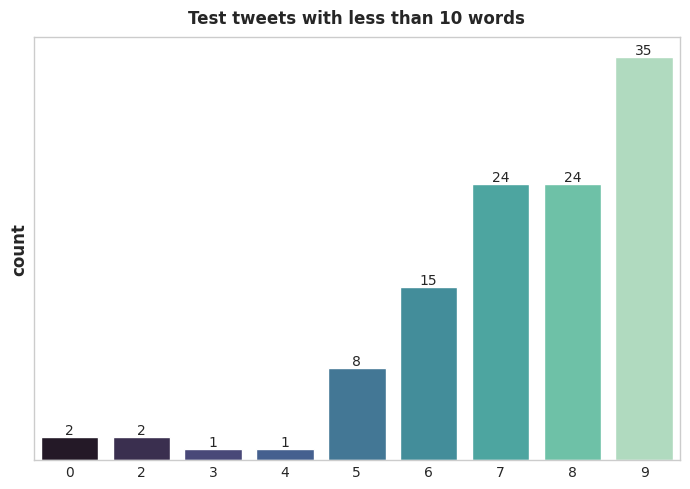

In [39]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df_test[df_test['text_len']<10], palette='mako')
plt.title('Test tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

As we can see, there are lots of cleaned tweets with 0 words: this is due to the cleaning performed before. This means that some tweets contained only mentions, hashtags and links, which have been removed. We will drop these empty tweets and also those with less than 5 words.

In [40]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (41157, 4)
 DF TEST SHAPE: (3798, 4)


In [41]:
df = df[df['text_len'] > 4]

In [42]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (40935, 4)
 DF TEST SHAPE: (3798, 4)


###  Performing Tokenization

In [45]:
from transformers import BertTokenizerFast

In [46]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [47]:
token_lens = []

for txt in df['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
max_len=np.max(token_lens)

In [48]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 100


### Let's check the long tokenized sentences (with more than 80 tokens ):

In [49]:
token_lens = []

for i,txt in enumerate(df['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")  

INDEX: 1622, TEXT: zsah policie proti spekulantm s roukami na mj popud hejtman steckho kraje ve spoluprci s podle krizovho zkona zajistil tm 700 tisrouek od firmy kter je mla dodat na zdravotnkm ale na posledn chvli se snaila navyovat cenu spolutozvladneme
INDEX: 13623, TEXT: hoy aplaudo a mi segunda familia aplaudoanuestrosheroes aquellos con los que he compartido tantas noches de trabajo y tanta alegra s que como siempre dan todo por el bien de su comunidad presidente por ellos tambin cuarentenanacionalya cuidemosalosquecuidan
INDEX: 16548, TEXT: bir mddettir spermarketlerin lojistik hizmeti avusturya ordusu desteiyle yaplyor dn corona tedavisi iin 22 milyon luk bir aratrma gelitirme btesi aklad hkmet geen hafta da 35 milyon luk 2 yardm paketi aklanmt viyanadan haberler bu kadar
INDEX: 36953, TEXT: 11 nisan cumartesi itibariyle bbnin tm hizmetleri sokaa kma serbestisi olanlar iin devam edecek halk ekmek ve hamidiye su 100 retime geti bb tm stanbulun gda ihtiyacna yetecek kapasitededi

These sentences are not in english. They should be dropped.

In [50]:
df['token_lens'] = token_lens

In [51]:
df = df.sort_values(by='token_lens', ascending=False)
df.head(20)

OriginalTweet           Sentiment  \
1638   ZÃ¡sah policie proti spekulant?m s rouÂkami. ...             Neutral   
37156  11 Nisan Cumartesi itibariyle ?BBÂnin tÃ¼m hi...             Neutral   
16632  Bir mÃ¼ddettir sÃ¼permarketlerin lojistik hizm...             Neutral   
13691  Hoy aplaudo a mi segunda familia #AplaudoANues...             Neutral   
27005  Supermercados Econo confirman que un empleado ...             Neutral   
14593  Na, wer war denn da am Werk? Gestern Nachmitta...  Extremely Negative   
28899  Kindly contact Us bamy global merchandise for ...            Positive   
11213  Keine WertgegenstÃ¤nde im Fahrzeug lassen! - D...            Negative   
4844   Impct of #coronavirus i hve sen hw civilizd pp...  Extremely Negative   
18913  #CroozefmNews \r\r\nPresident Museveni has ord...  Extremely Negative   
30206  #LDA City Lahore Residential Files Prices Upda...             Neutral   
26678  Eine wahre #CoronaGeschichte:\r\r\n\r\r\nWenn ...             Neutral   
12389  Okay, so I just checked the drug prices for #P...            Positive   
1697   I work at a grocery store.\r\r\nWe wont get an...            Positive   
8730   ?Bitte anschauen! (1/2)\r\r\n\r\r\nEmotionaler...            Negative   
14582  hiked prices in the face of the Covid-19 crise...            Negative   
36305  Sterile disposable anti bacterial wet wipes an...            Negative   
36306  For sell Sterile disposable anti bacterial wet...            Negative   
9238   Hi @Zomato I felt hungry loggd in ur app tryd ...  Extremely Positive   
40778  #Covid_19 2days Stay-at-home activities\r\r\nU...             Neutral   

                                              text_clean  text_len  token_lens  
1638   zsah policie proti spekulantm s roukami na mj ...        39         100  
37156  11 nisan cumartesi itibariyle bbnin tm hizmetl...        39          98  
16632  bir mddettir spermarketlerin lojistik hizmeti ...        36          92  
13691  hoy aplaudo a mi segunda familia aplaudoanuest...        38          84  
27005  supermercados econo confirman que un empleado ...        39          80  
14593  na wer war denn da am werk gestern nachmittag ...        37          80  
28899  kindly contact us bamy global merchandise for ...        37          80  
11213  keine wertgegenstnde im fahrzeug lassen diesen...        33          79  
4844   impct of coronavirus i hve sen hw civilizd ppl...        48          79  
18913  croozefmnews president museveni has ordered th...        35          79  
30206  lda city lahore residential files prices updat...        43          78  
26678  eine wahre coronageschichte wenn dir an der su...        29          78  
12389  okay so i just checked the drug prices for pla...        35          77  
1697   i work at a grocery store we wont get any toil...        37          77  
8730   bitte anschauen 12 emotionaler aufruf von geha...        36          77  
14582  hiked prices in the face of the covid19 crises...        47          77  
36305  sterile disposable anti bacterial wet wipes an...        31          76  
36306  for sell sterile disposable anti bacterial wet...        32          75  
9238   hi i felt hungry loggd in ur app tryd to add 4...        55          75  
40778  covid19 2days stayathome activities up 630am f...        37          75

In [52]:
df = df.iloc[12:]
df.head()

OriginalTweet Sentiment  \
12389  Okay, so I just checked the drug prices for #P...  Positive   
1697   I work at a grocery store.\r\r\nWe wont get an...  Positive   
8730   ?Bitte anschauen! (1/2)\r\r\n\r\r\nEmotionaler...  Negative   
14582  hiked prices in the face of the Covid-19 crise...  Negative   
36305  Sterile disposable anti bacterial wet wipes an...  Negative   

                                              text_clean  text_len  token_lens  
12389  okay so i just checked the drug prices for pla...        35          77  
1697   i work at a grocery store we wont get any toil...        37          77  
8730   bitte anschauen 12 emotionaler aufruf von geha...        36          77  
14582  hiked prices in the face of the covid19 crises...        47          77  
36305  sterile disposable anti bacterial wet wipes an...        31          76

The dataset looks more clean now. We will shuffle it and reset the index.

In [53]:
df = df.sample(frac=1).reset_index(drop=True)

In [61]:
df.to_csv('covid_19_Cleaned_data.csv')

# Test data deeper cleaning

We will perform the data cleaning based on the tokenized sentences on the test set.

In [54]:
token_lens_test = []

for txt in df_test['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    
max_len=np.max(token_lens_test)

In [55]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 96


In [56]:
token_lens_test = []

for i,txt in enumerate(df_test['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 286, TEXT: so hard to decide as much as i want to hodl my 2 ccdcv4 token our place is declared to lock down due to covid19 i will use this to buy some food to stock txnid093bd1db0c0d3a62af15883138a5f57d4cef35ae14e31e602b74489dd2524c7f my b
INDEX: 345, TEXT: informoval jsem zstupce vech obchodnch etzc o aktulnch opatench vldy etzce jsou zsobovny na 95 take nen dvod panikait zsoby potravin fakt nedojdou nen opravdu dvod dnes obsadit a vykoupit supermarkety
INDEX: 2383, TEXT: ahora seguid llorando por el papel higinico que no he comprado porque an tengo seguid creando histeria y preocupacin poniendo fotos de gente en pnico y estanteras vacas que yo seguir yendo a comercios responsables de barrio donde nos cuidan hoy y siempre gracias


In [57]:
df_test['token_lens'] = token_lens_test

In [58]:
df_test = df_test.sort_values(by='token_lens', ascending=False)
df_test.head(10) 

OriginalTweet           Sentiment  \
286   @Rhett800cc So hard to decide??. As much as I ...            Negative   
2383  Ahora seguid llorando por el papel higiénico (...            Negative   
345   Informoval jsem zástupce vech obchodních ?et?...             Neutral   
1485  DTF-Dont Touch Face\r\r\nDWBH-Do Wash Both Ha...  Extremely Negative   
1209  Im in the DC/Maryland/Virginia (DMV) area &am...            Positive   
3505  Stop misusing ur privilege amp grow up Some1 c...            Positive   
1789  For those that are cashlong, patient,calm&amp;...  Extremely Positive   
2997  Stop #frenzybuying. You don't need most of wha...  Extremely Negative   
855   Lidl is total chaos, queues as long as the ais...  Extremely Negative   
2740  COVID-19: Your government will save ITSELF not...            Positive   

                                             text_clean  text_len  token_lens  
286   so hard to decide as much as i want to hodl my...        38          96  
2383  ahora seguid llorando por el papel higinico qu...        44          94  
345   informoval jsem zstupce vech obchodnch etzc o ...        31          86  
1485  dtfdont touch face dwbhdo wash both hands gtfo...        42          77  
1209  im in the dcmarylandvirginia dmv area amphave ...        45          74  
3505  stop misusing ur privilege amp grow up some1 c...        57          73  
1789  for those that are cashlong patientcalmamphave...        44          71  
2997  stop frenzybuying you dont need most of what y...        38          70  
855   lidl is total chaos queues as long as the aisl...        62          70  
2740  covid19 your government will save itself not y...        43          70

In [59]:
df_test = df_test.iloc[5:]
df_test.head(3)

OriginalTweet           Sentiment  \
3505  Stop misusing ur privilege amp grow up Some1 c...            Positive   
1789  For those that are cashlong, patient,calm&amp;...  Extremely Positive   
2997  Stop #frenzybuying. You don't need most of wha...  Extremely Negative   

                                             text_clean  text_len  token_lens  
3505  stop misusing ur privilege amp grow up some1 c...        57          73  
1789  for those that are cashlong patientcalmamphave...        44          71  
2997  stop frenzybuying you dont need most of what y...        38          70

In [60]:
df_test = df_test.sample(frac=1).reset_index(drop=True)

In [62]:
df_test.to_csv('Covid_19_Cleaned_TestData.csv')